In [1]:
# General comments 
# Dataset: CNN_daily_mail
# Metrics: BLEU scores

In [46]:
import transformers
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import random
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
from transformers import BigBirdTokenizer, BigBirdModel
from transformers import BigBirdForMaskedLM, BigBirdTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
num_samples = 200
dataset = load_dataset("cnn_dailymail", "3.0.0", split='validation[100:300]')

In [65]:
def generate_summary(text, tokenizer, model):
    inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    output = model.generate(input_ids, attention_mask=attention_mask)
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [77]:
def mask_sequence_based_on_past_likelihoods(tokenizer, tokenized, sent1_lengths, orig_token_mask, token_probs_hist, seed_num, 
                                       percentage_init=0.35, percentage_of_min_likelihoods_to_mask=0.2):
    if percentage_of_min_likelihoods_to_mask>=percentage_init:
        raise ValueError("percentage_of_min_likelihoods_to_mask must be less than percentage_init since we cannot re-mask tokens that have not been masked earlier!")
    if orig_token_mask is None:
        token_mask = torch.bernoulli(torch.full(tokenized["attention_mask"].shape, percentage_init), generator=torch.manual_seed(seed_num))
        token_mask = torch.logical_and(token_mask, tokenized["attention_mask"])
        for i in range(len(token_mask)):
            token_mask[i, :sent1_lengths] = 0
    else:
        # token_mask = torch.bernoulli(torch.full(tokenized["attention_mask"].shape, percentage_next), generator=torch.manual_seed(seed_num))
        token_mask = torch.zeros(tokenized["attention_mask"].shape)
        indices_to_mask = torch.topk(token_probs_hist, k=3, dim=-1, largest=False).indices
        token_mask = token_mask.scatter(dim=1, index=indices_to_mask, value=1)

        # token_mask2 = torch.bernoulli(torch.full(tokenized["attention_mask"].shape, percentage_next), generator=torch.manual_seed(seed_num))
        # token_mask = torch.logical_or(token_mask, token_mask2)
        
        # token_mask = torch.where(token_probs_hist<0.3,1,0)
        token_mask = torch.logical_and(token_mask, orig_token_mask)
    
    inp_ids = tokenized["input_ids"]
    inp_ids[token_mask==1]=tokenizer.mask_token_id
    tokenized["input_ids"] = inp_ids
    non_pad_lengths = torch.sum(tokenized["attention_mask"], dim=-1)
    return tokenized, token_mask, non_pad_lengths

In [67]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-small2bert-small-finetuned-cnn_daily_mail-summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/bert-small2bert-small-finetuned-cnn_daily_mail-summarization")
summaries_initial = [generate_summary(article['article'], tokenizer, model) for article in dataset]

In [69]:
rouge = load_metric('rouge')
bleu = load_metric('sacrebleu')

rouge_scores_initial = rouge.compute(predictions=summaries_initial, references=[article['highlights'] for article in dataset])
bleu_scores_initial = bleu.compute(predictions=summaries_initial, references=[[article['highlights']] for article in dataset])

print("ROUGE Scores:", rouge_scores_initial)
print("BLEU-4 Score:", bleu_scores_initial['score'])

ROUGE Scores: {'rouge1': AggregateScore(low=Score(precision=0.0784313725490196, recall=0.17391304347826086, fmeasure=0.10810810810810811), mid=Score(precision=0.10939112487100103, recall=0.22981366459627328, fmeasure=0.14817170111287759), high=Score(precision=0.14035087719298245, recall=0.2857142857142857, fmeasure=0.18823529411764706)), 'rouge2': AggregateScore(low=Score(precision=0.0, recall=0.0, fmeasure=0.0), mid=Score(precision=0.01, recall=0.022727272727272728, fmeasure=0.013888888888888888), high=Score(precision=0.02, recall=0.045454545454545456, fmeasure=0.027777777777777776)), 'rougeL': AggregateScore(low=Score(precision=0.0784313725490196, recall=0.17391304347826086, fmeasure=0.10810810810810811), mid=Score(precision=0.09184726522187822, recall=0.19409937888198758, fmeasure=0.1246422893481717), high=Score(precision=0.10526315789473684, recall=0.21428571428571427, fmeasure=0.1411764705882353)), 'rougeLsum': AggregateScore(low=Score(precision=0.0784313725490196, recall=0.173913

In [70]:
def mask_tokens(summary, frac, tokenizer_mlm, nums = -1):
    words = summary.split()
    if nums == -1:
        num_to_mask = int(len(words) * frac)
    else:
        num_to_mask = nums
    masked_indices = random.sample(range(len(words)), num_to_mask)
    for idx in masked_indices:
        words[idx] = tokenizer_mlm.mask_token
    return " ".join(words), masked_indices

In [71]:
# tokenizer_mlm = BertTokenizer.from_pretrained("bert-large-cased-whole-word-masking")
# model_mlm = BertForMaskedLM.from_pretrained("bert-large-cased-whole-word-masking")
tokenizer_mlm = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')
model_mlm = BigBirdForMaskedLM.from_pretrained('google/bigbird-roberta-base')

# Add a new special SEP token if it's not already in the tokenizer
special_token = "<|sep|>"
# if special_token not in tokenizer_mlm.get_added_vocab():
#     tokenizer_mlm.add_tokens([special_token])

# rouge_scores = [rouge_scores_initial]
# bleu_scores = [bleu_scores_initial['score']]
rouge_scores_nolike = [rouge_scores_initial]
bleu_scores_nolike = [bleu_scores_initial['score']]
num_iterations = 10
frac_tokens_masked = 0.2

summaries = summaries_initial

for iteration in tqdm(range(num_iterations), desc="Iterations"):
    new_summaries = []
    
    for idx, article in enumerate(dataset):
        current_summary = summaries[idx]
        masked_summary,_ = mask_tokens(current_summary, frac_tokens_masked, tokenizer_mlm)
        
        input_text = article['article'] + special_token + masked_summary
        # print (input_text)
        inputs = tokenizer_mlm(input_text, return_tensors="pt")
        mask_token_index = torch.where(inputs.input_ids == tokenizer_mlm.mask_token_id)[1]
        
        # outputs = model_mlm.generate(**inputs)
        outputs = model_mlm(**inputs)
        predictions = outputs.logits
        predicted_tokens = torch.argmax(predictions, dim=-1)
        
        # replace masks with predicted tokens
        predicted_ids = inputs.input_ids.clone()
        # print predicted_ids and predicted_tokens shape
        for mask_index in mask_token_index:
            predicted_ids[0, mask_index] = predicted_tokens[0, mask_index]
            
        # extract predicted highlight from total predicted text
        predicted_text = tokenizer_mlm.decode(predicted_ids[0], skip_special_tokens=True)
        
        # print predicted_text and article
        # print (predicted_text)
        # print ('\n')
        # print (article['article'])
        
        # separate predicted highlight from predicted text
        new_summary = predicted_text.split(special_token)[1]
        new_summaries.append(new_summary)

    # Evaluation
    rouge_score = rouge.compute(predictions=new_summaries, references=[article['highlights'] for article in dataset])
    bleu_score = bleu.compute(predictions=new_summaries, references=[[article['highlights']] for article in dataset])
    rouge_scores_nolike.append(rouge_score)
    bleu_scores_nolike.append(bleu_score['score'])
    # print ("Iteration: ", iteration)
    
    # print first 2 summaries and reference highlights elementwise intertwined
    # for i in range(2):
    #     print ("Summary: ", new_summaries[i])
    #     print ("Reference: ", dataset[i]['highlights'])
    #     print ("")
        
    # put new summaries in summaries
    summaries = new_summaries

Iterations: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


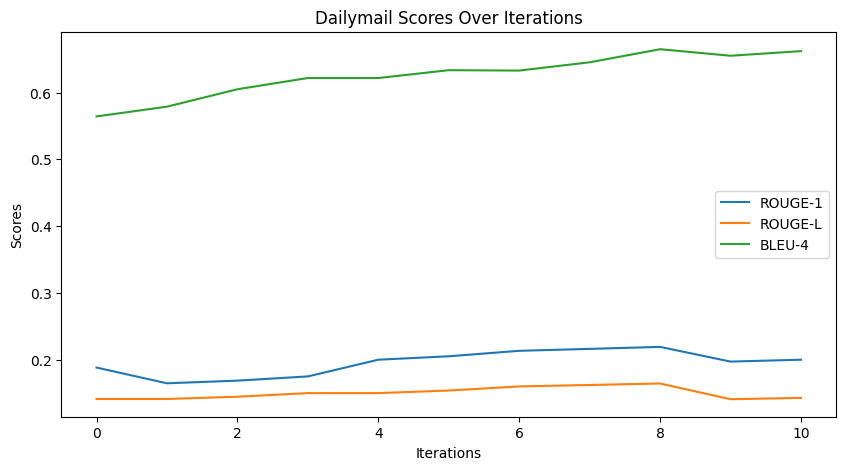

In [72]:
iterations = list(range(0, num_iterations + 1))
plt.figure(figsize=(10, 5))
plt.plot(iterations, [score['rouge1'].high.fmeasure for score in rouge_scores_nolike], label='ROUGE-1')
plt.plot(iterations, [score['rougeL'].high.fmeasure for score in rouge_scores_nolike], label='ROUGE-L')
plt.plot(iterations, bleu_scores_nolike, label='BLEU-4')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Dailymail Scores Over Iterations')
plt.legend()
plt.show()


In [73]:
# code to start by masking all tokens at once, and end with masking one token at a time
# tokenizer_mlm = BertTokenizer.from_pretrained("bert-large-cased-whole-word-masking")
# model_mlm = BertForMaskedLM.from_pretrained("bert-large-cased-whole-word-masking")
tokenizer_mlm = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')
model_mlm = BigBirdForMaskedLM.from_pretrained('google/bigbird-roberta-base')

# Add a new special SEP token if it's not already in the tokenizer
special_token = "<|sep|>"
# if special_token not in tokenizer_mlm.get_added_vocab():
#     tokenizer_mlm.add_tokens([special_token])

# rouge_scores = [rouge_scores_initial]
# bleu_scores = [bleu_scores_initial['score']]
rouge_scores = [rouge_scores_initial]
bleu_scores = [bleu_scores_initial['score']]
num_iterations = 1
frac_tokens_masked = 0.1
num_iterations_mask_all = 0
num_iterations_mask_one = num_iterations - num_iterations_mask_all
num_mask_one = 3

summaries = summaries_initial

for iteration in tqdm(range(num_iterations), desc="Iterations"):
    new_summaries = []
    
    for idx, article in enumerate(dataset):
        current_summary = summaries[idx]
        
        if iteration <= num_iterations_mask_all:
            masked_summary,_ = mask_tokens(current_summary, frac_tokens_masked, tokenizer_mlm)
        else:
            masked_summary,_ = mask_tokens(current_summary, frac_tokens_masked, tokenizer_mlm, nums = num_mask_one)
        
        input_text = article['article'] + special_token + masked_summary
        # print (input_text)
        inputs = tokenizer_mlm(input_text, return_tensors="pt")
        mask_token_index = torch.where(inputs.input_ids == tokenizer_mlm.mask_token_id)[1]
        
        # outputs = model_mlm.generate(**inputs)
        outputs = model_mlm(**inputs)
        predictions = outputs.logits
        predicted_tokens = torch.argmax(predictions, dim=-1)
        
        # replace masks with predicted tokens
        predicted_ids = inputs.input_ids.clone()
        # print predicted_ids and predicted_tokens shape
        for mask_index in mask_token_index:
            predicted_ids[0, mask_index] = predicted_tokens[0, mask_index]
            
        # extract predicted highlight from total predicted text
        predicted_text = tokenizer_mlm.decode(predicted_ids[0], skip_special_tokens=True)
        
        # print predicted_text and article
        # print (predicted_text)
        # print ('\n')
        # print (article['article'])
        
        # separate predicted highlight from predicted text
        new_summary = predicted_text.split(special_token)[1]
        new_summaries.append(new_summary)

    # Evaluation
    rouge_score = rouge.compute(predictions=new_summaries, references=[article['highlights'] for article in dataset])
    bleu_score = bleu.compute(predictions=new_summaries, references=[[article['highlights']] for article in dataset])
    rouge_scores.append(rouge_score)
    bleu_scores.append(bleu_score['score'])
    # print ("Iteration: ", iteration)
    
    # print first 2 summaries and reference highlights elementwise intertwined
    # for i in range(2):
    #     print ("Summary: ", new_summaries[i])
    #     print ("Reference: ", dataset[i]['highlights'])
    #     print ("")
        
    # put new summaries in summaries
    summaries = new_summaries

Iterations: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


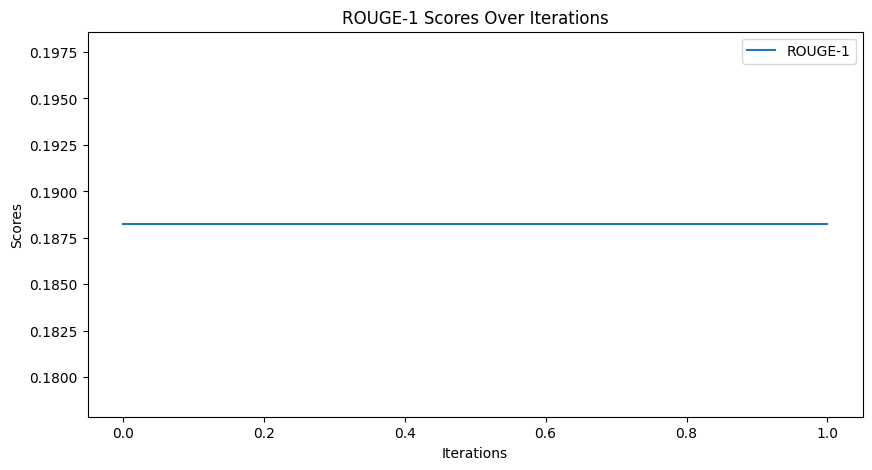

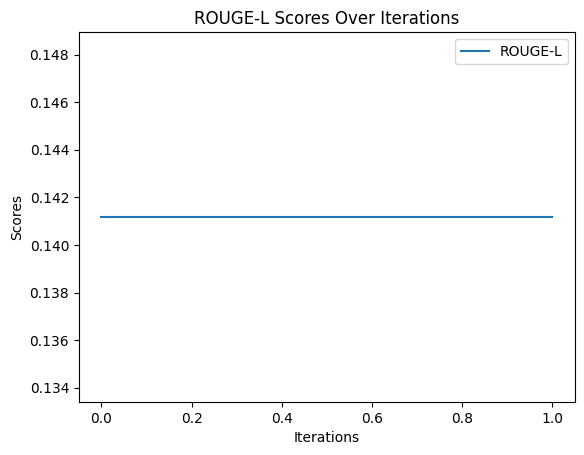

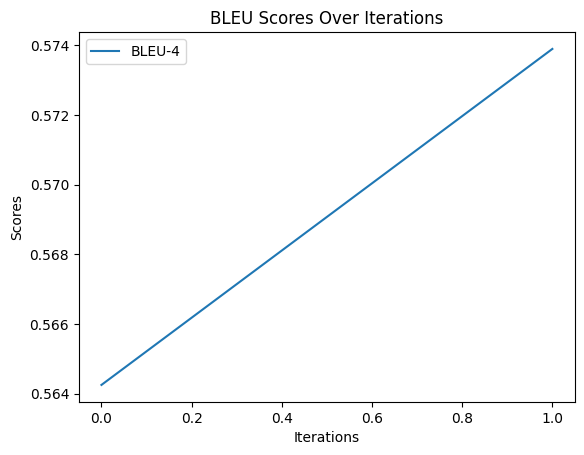

In [74]:
iterations = list(range(0, num_iterations + 1))
plt.figure(figsize=(10, 5))
plt.plot(iterations, [score['rouge1'].high.fmeasure for score in rouge_scores], label='ROUGE-1')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('ROUGE-1 Scores Over Iterations')
plt.legend()
plt.show()

plt.plot(iterations, [score['rougeL'].high.fmeasure for score in rouge_scores], label='ROUGE-L')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('ROUGE-L Scores Over Iterations')
plt.legend()
plt.show()

plt.plot(iterations, bleu_scores, label='BLEU-4')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('BLEU Scores Over Iterations')
plt.legend()
plt.show()

In [75]:
def unmask_tokens_and_return_likelihoods(tokenized, token_mask, non_pad_lengths, output, masked_sentence_hist, unmasked_sentence_hist, token_probs_hist):
    unmasked_tokens_list = []
    output_probs = torch.nn.Softmax(dim=-1)(output.logits)
    predicted_tokens_all = torch.argmax(output_probs, dim=-1)
    predicted_token_prob_all = torch.amax(output_probs, dim=-1)
    for i in range(len(output.logits)):
        # Masked sentence
        masked_sentence_hist[i].append(tokenizer.decode(tokenized["input_ids"][i][1:non_pad_lengths[i]-1])) 
        unmasked_tokens = torch.where(token_mask[i]==1, predicted_tokens_all[i], tokenized["input_ids"][i])
        token_probs_hist[i] = torch.where(token_mask[i]==1, predicted_token_prob_all[i], token_probs_hist[i])

        unmasked_tokens_list.append(unmasked_tokens)

        # Sentence with mask replaced
        unmasked_sentence_hist[i].append(tokenizer.decode(unmasked_tokens[1:non_pad_lengths[i]-1])) 

    return torch.stack(unmasked_tokens_list, axis=0)

In [78]:
# Likelihood based masking, and unmasking tokens one by one

# tokenizer_mlm = BertTokenizer.from_pretrained("bert-large-cased-whole-word-masking")
# model_mlm = BertForMaskedLM.from_pretrained("bert-large-cased-whole-word-masking")
tokenizer_mlm = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')
model_mlm = BigBirdForMaskedLM.from_pretrained('google/bigbird-roberta-base')

# Add a new special SEP token if it's not already in the tokenizer
special_token = "<|sep|>"
# if special_token not in tokenizer_mlm.get_added_vocab():
#     tokenizer_mlm.add_tokens([special_token])

# rouge_scores = [rouge_scores_initial]
# bleu_scores = [bleu_scores_initial['score']]
rouge_scores_like = [rouge_scores_initial]
bleu_scores_like = [bleu_scores_initial['score']]
num_iterations = 10
frac_tokens_masked = 0.1
num_iterations_mask_all = 0
num_iterations_mask_one = num_iterations - num_iterations_mask_all
num_mask_one = 1

summaries = summaries_initial

orig_token_mask = [None]*len(dataset)
token_mask = [None]*len(dataset)
masked_sentence_hist = [list() for _ in range(len(dataset))]
unmasked_sentence_hist = [list() for _ in range(len(dataset))]
token_probs_hist = [list() for _ in range(len(dataset))]
token_probs_curr = [None]*len(dataset)

for iteration in tqdm(range(num_iterations), desc="Iterations"):
    new_summaries = []
    
    for idx, article in enumerate(dataset):
        current_summary = summaries[idx]
        
        tokenized_article = tokenizer_mlm(article['article'] + special_token)
        article_tokens_length = len(tokenized_article["attention_mask"])
        joint_sentences = article['article'] + special_token + current_summary
        tokenized_whole = tokenizer_mlm(joint_sentences, padding=True, return_tensors='pt')
        
        if iteration <= num_iterations_mask_all:
            masked_summary,_ = mask_tokens(current_summary, frac_tokens_masked, tokenizer_mlm)
        else:
            # masked_summary,_ = mask_tokens(current_summary, frac_tokens_masked, tokenizer_mlm, nums = num_mask_one)
            tokenized_whole, token_mask, non_pad_lengths = mask_sequence_based_on_past_likelihoods(tokenizer_mlm, tokenized_whole, article_tokens_length,
                                                                                             orig_token_mask[idx], torch.Tensor(token_probs_hist[idx]), seed_num = iteration)
            if orig_token_mask[idx] is None:
                orig_token_mask[idx] = token_mask
                
        
        mask_token_index = torch.where(tokenized_whole.input_ids == tokenizer_mlm.mask_token_id)[1]
        
        # outputs = model_mlm.generate(**inputs)
        outputs = model_mlm(**tokenized_whole)
        predictions = outputs.logits
        predicted_tokens = torch.argmax(predictions, dim=-1)
        
        # replace masks with predicted tokens
        predicted_ids = tokenized_whole.input_ids.clone()
        # print predicted_ids and predicted_tokens shape
        for mask_index in mask_token_index:
            predicted_ids[0, mask_index] = predicted_tokens[0, mask_index]
        
        # extract predicted highlight from total predicted text
        predicted_text = tokenizer_mlm.decode(predicted_ids[0], skip_special_tokens=True)
        
        # print predicted_text and article
        print (predicted_text)
        print ('\n')
        print (article['article'])
        
        # separate predicted highlight from predicted text
        new_summary = predicted_text.split(special_token)[1]
        new_summaries.append(new_summary)

    # Evaluation
    rouge_score = rouge.compute(predictions=new_summaries, references=[article['highlights'] for article in dataset])
    bleu_score = bleu.compute(predictions=new_summaries, references=[[article['highlights']] for article in dataset])
    rouge_scores_like.append(rouge_score)
    bleu_scores_like.append(bleu_score['score'])
    # print ("Iteration: ", iteration)
    
    # print first 2 summaries and reference highlights elementwise intertwined
    # for i in range(2):
    #     print ("Summary: ", new_summaries[i])
    #     print ("Reference: ", dataset[i]['highlights'])
    #     print ("")
        
    # put new summaries in summaries
    summaries = new_summaries

Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I'm just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard's gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacific Medical Center 

Iterations:  10%|█         | 1/10 [00:02<00:20,  2.23s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  20%|██        | 2/10 [00:04<00:15,  1.98s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  30%|███       | 3/10 [00:05<00:13,  1.91s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  40%|████      | 4/10 [00:07<00:11,  1.86s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  50%|█████     | 5/10 [00:09<00:09,  1.83s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  60%|██████    | 6/10 [00:11<00:07,  1.81s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  70%|███████   | 7/10 [00:13<00:05,  1.81s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  80%|████████  | 8/10 [00:14<00:03,  1.82s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  90%|█████████ | 9/10 [00:16<00:01,  1.81s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

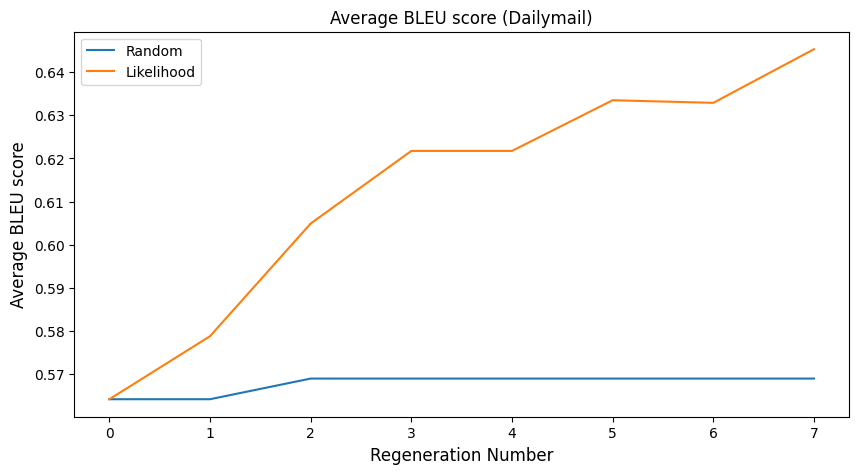

In [79]:
iterations = list(range(0, num_iterations -2))
plt.figure(figsize=(10, 5))
plt.plot(iterations, bleu_scores_nolike[:-3], label='Random')
plt.plot(iterations, bleu_scores_like[:-3], label='Likelihood')

plt.xlabel('Regeneration Number', fontsize = 12)
plt.ylabel('Average BLEU score', fontsize = 12)
plt.title('Average BLEU score (Dailymail)')
plt.legend()
plt.show()

In [80]:
def mask_sequence_based_on_past_likelihoods_with_exploration(tokenized, sent1_lengths, orig_token_mask, token_probs_hist, seed_num = 100, 
                                       percentage_init=0.35, percentage_next = 0.15, percentage_of_min_likelihoods_to_mask=0.2):
    if percentage_of_min_likelihoods_to_mask>=percentage_init:
        raise ValueError("percentage_of_min_likelihoods_to_mask must be less than percentage_init since we cannot re-mask tokens that have not been masked earlier!")
    if orig_token_mask is None:
        token_mask = torch.bernoulli(torch.full(tokenized["attention_mask"].shape, percentage_init), generator=torch.manual_seed(seed_num))
        token_mask = torch.logical_and(token_mask, tokenized["attention_mask"])
        for i in range(len(token_mask)):
            token_mask[i, :sent1_lengths[i]] = 0
    else:
        # token_mask = torch.bernoulli(torch.full(tokenized["attention_mask"].shape, percentage_next), generator=torch.manual_seed(seed_num))
        token_mask = torch.zeros(tokenized["attention_mask"].shape)
        indices_to_mask = torch.topk(token_probs_hist, k=3, dim=-1, largest=False).indices
        token_mask = token_mask.scatter(dim=1, index=indices_to_mask, value=1)

        token_mask2 = torch.bernoulli(torch.full(tokenized["attention_mask"].shape, percentage_next), generator=torch.manual_seed(seed_num))
        token_mask = torch.logical_or(token_mask, token_mask2)
        # make token_mask same shape as orig_token_mask by pruning
        if orig_token_mask.shape[1] > token_mask.shape[1]:
            orig_token_mask = orig_token_mask[:, :token_mask.shape[1]]
        else:
            # concatenate orig_token_mask with zeros
            orig_token_mask = torch.cat((orig_token_mask, torch.zeros(orig_token_mask.shape[0], 
                                                                      token_mask.shape[1] - orig_token_mask.shape[1])), dim=1)

        # token_mask = torch.where(token_probs_hist<0.3,1,0)
        token_mask = torch.logical_and(token_mask, orig_token_mask)
    
    inp_ids = tokenized["input_ids"]
    inp_ids[token_mask==1]=tokenizer_mlm.mask_token_id
    tokenized["input_ids"] = inp_ids
    non_pad_lengths = torch.sum(tokenized["attention_mask"], dim=-1)
    return tokenized, token_mask, non_pad_lengths

In [81]:
# Likelihood based masking with exploration, and unmasking tokens one by one

# tokenizer_mlm = BertTokenizer.from_pretrained("bert-large-cased-whole-word-masking")
# model_mlm = BertForMaskedLM.from_pretrained("bert-large-cased-whole-word-masking")
tokenizer_mlm = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')
model_mlm = BigBirdForMaskedLM.from_pretrained('google/bigbird-roberta-base')

# Add a new special SEP token if it's not already in the tokenizer
special_token = "<|sep|>"
# if special_token not in tokenizer_mlm.get_added_vocab():
#     tokenizer_mlm.add_tokens([special_token])

# rouge_scores = [rouge_scores_initial]
# bleu_scores = [bleu_scores_initial['score']]
rouge_scores_like = [rouge_scores_initial]
bleu_scores_likeExplore = [bleu_scores_initial['score']]
num_iterations = 10
frac_tokens_masked = 0.1
num_iterations_mask_all = 0
num_iterations_mask_one = num_iterations - num_iterations_mask_all
num_mask_one = 1

summaries = summaries_initial

orig_token_mask = [None]*len(dataset)
token_mask = [None]*len(dataset)
masked_sentence_hist = [list() for _ in range(len(dataset))]
unmasked_sentence_hist = [list() for _ in range(len(dataset))]
token_probs_hist = [list() for _ in range(len(dataset))]
token_probs_curr = [None]*len(dataset)

for iteration in tqdm(range(num_iterations), desc="Iterations"):
    new_summaries = []
    
    for idx, article in enumerate(dataset):
        current_summary = summaries[idx]
        
        tokenized_article = tokenizer_mlm(article['article'] + special_token)
        article_tokens_length = [len(tokenized_article["attention_mask"])]
        joint_sentences = article['article'] + special_token + current_summary
        tokenized_whole = tokenizer_mlm(joint_sentences, padding=True, return_tensors='pt')
        
        if iteration <= num_iterations_mask_all:
            masked_summary,_ = mask_tokens(current_summary, frac_tokens_masked, tokenizer_mlm)
        else:
            # masked_summary,_ = mask_tokens(current_summary, frac_tokens_masked, tokenizer_mlm, nums = num_mask_one)
            tokenized_whole, token_mask, non_pad_lengths = mask_sequence_based_on_past_likelihoods_with_exploration(
               tokenized_whole, article_tokens_length, orig_token_mask[idx], torch.Tensor(token_probs_hist[idx]), seed_num = 100, 
                                       percentage_init=0.35, percentage_next = 0.15, percentage_of_min_likelihoods_to_mask=0.2)
            if orig_token_mask[idx] is None:
                orig_token_mask[idx] = token_mask
                
        
        mask_token_index = torch.where(tokenized_whole.input_ids == tokenizer_mlm.mask_token_id)[1]
        
        # outputs = model_mlm.generate(**inputs)
        outputs = model_mlm(**tokenized_whole)
        predictions = outputs.logits
        predicted_tokens = torch.argmax(predictions, dim=-1)
        
        # replace masks with predicted tokens
        predicted_ids = tokenized_whole.input_ids.clone()
        # print predicted_ids and predicted_tokens shape
        for mask_index in mask_token_index:
            predicted_ids[0, mask_index] = predicted_tokens[0, mask_index]
        
        # extract predicted highlight from total predicted text
        predicted_text = tokenizer_mlm.decode(predicted_ids[0], skip_special_tokens=True)
        
        # print predicted_text and article
        print (predicted_text)
        print ('\n')
        print (article['article'])
        
        # separate predicted highlight from predicted text
        new_summary = predicted_text.split(special_token)[1]
        new_summaries.append(new_summary)

    # Evaluation
    rouge_score = rouge.compute(predictions=new_summaries, references=[article['highlights'] for article in dataset])
    bleu_score = bleu.compute(predictions=new_summaries, references=[[article['highlights']] for article in dataset])
    rouge_scores_like.append(rouge_score)
    bleu_scores_likeExplore.append(bleu_score['score'])
    # print ("Iteration: ", iteration)
    
    # print first 2 summaries and reference highlights elementwise intertwined
    # for i in range(2):
    #     print ("Summary: ", new_summaries[i])
    #     print ("Reference: ", dataset[i]['highlights'])
    #     print ("")
        
    # put new summaries in summaries
    summaries = new_summaries

Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I'm just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard's gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacific Medical Center 

Iterations:  10%|█         | 1/10 [00:02<00:21,  2.36s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  20%|██        | 2/10 [00:04<00:16,  2.06s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  30%|███       | 3/10 [00:05<00:13,  1.92s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  40%|████      | 4/10 [00:07<00:11,  1.85s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  50%|█████     | 5/10 [00:09<00:09,  1.81s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  60%|██████    | 6/10 [00:11<00:07,  1.79s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  70%|███████   | 7/10 [00:12<00:05,  1.79s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  80%|████████  | 8/10 [00:14<00:03,  1.81s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations:  90%|█████████ | 9/10 [00:16<00:01,  1.79s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

Iterations: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn for the world's favorite sport in a land its charms had yet to conquer. Summarizing the action for ESPN, commentator Ty Keough eagerly described the momentous "birth of a new era for American soccer." Looking back at footage from that balmy evening now it's hard not to feel a certain nostalgia. Baggy shirts, questionable hairstyles and strange rule adaptations to make games more exciting were all part of the formative MLS experience. Countdown clocks were employed to provide drama at the end of each half. Even more bizarrely, tied games were settled by shootouts that saw attacking players run with the ball from 35-yards out before attempting to beat the opposing goalkeeper. As the MLS prepares to mark the beginning of its 20th season, it's hard to co

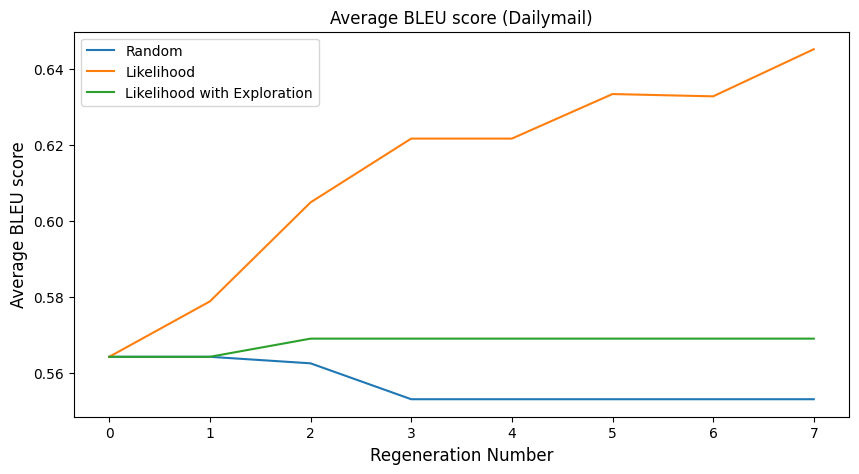

In [82]:
iterations = list(range(0, num_iterations -2))
plt.figure(figsize=(10, 5))
plt.plot(iterations, bleu_scores_nolike[:-3], label='Random')
plt.plot(iterations, bleu_scores_like[:-3], label='Likelihood')
plt.plot(iterations, bleu_scores_likeExplore[:-3], label='Likelihood with Exploration')


plt.xlabel('Regeneration Number', fontsize = 12)
plt.ylabel('Average BLEU score', fontsize = 12)
plt.title('Average BLEU score (Dailymail)')
plt.legend()
plt.show()